<a href="https://colab.research.google.com/github/institutohumai/cursos-python/blob/master/CV/5_Deteccion_Objetos/ejercicios/ejercicios_solucion.ipynb"> <img src='https://colab.research.google.com/assets/colab-badge.svg' /> </a>

# Detección de objetos

## Data Augmentation.

En la clase, vimos como generar un modelo de detección de bananas. Sin embargo el modelo tiene un problema

<img src="https://i.imgur.com/MQydvw9.png" width="600" />

Nuestro modelo tiene problemas para detectar bananas no orientadas a la izquierda. Esto se debe a que nuestro dataset tiene mayoritariamente bananas curvadas a las izquierda y en mucha menor medida otras orientaciones. 

Para corregir esto, manipularemos las imagenes para crear más ejemplos en nuestro dataset. De esta manera pretendemos que estén igualmente representadas bananas orientadas a la izquierda, a la derecha, hacia arriba y hacia abajo.

Primero empezaremos trayendo todo el código que ya tenemos.

## Código Importado

In [ ]:

import torch
from matplotlib import pyplot as plt


In [ ]:
def box_corner_to_center(boxes):
    """Convert from (upper-left, lower-right) to (center, width, height)."""
    x1, y1, x2, y2 = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    w = x2 - x1
    h = y2 - y1
    boxes = torch.stack((cx, cy, w, h), axis=-1)
    return boxes

def box_center_to_corner(boxes):
    """Convert from (center, width, height) to (upper-left, lower-right)."""
    cx, cy, w, h = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    x1 = cx - 0.5 * w
    y1 = cy - 0.5 * h
    x2 = cx + 0.5 * w
    y2 = cy + 0.5 * h
    boxes = torch.stack((x1, y1, x2, y2), axis=-1)
    return boxes

In [ ]:
def bbox_to_rect(bbox, color):
    """Convert bounding box to matplotlib format."""
    # Matplotlib espera un bounding box de la forma 
    # (esquina superior a la izquierda x, esquina superior a la izquierda y,  ancho, alto)
    return plt.Rectangle(
        xy=(bbox[0], bbox[1]), width=bbox[2]-bbox[0], height=bbox[3]-bbox[1],
        fill=False, edgecolor=color, linewidth=2)

In [ ]:
def multibox_prior(data, sizes, ratios):
    """Generate anchor boxes with different shapes centered on each pixel."""

    # obtemos el ancho y el alto de la entrada 
    in_height, in_width = data.shape[-2:]

    # definimos la cantidad de anchor boxes y si usamos GPU o CPU
    device, num_sizes, num_ratios = data.device, len(sizes), len(ratios)
    boxes_per_pixel = (num_sizes + num_ratios - 1)
    size_tensor = torch.tensor(sizes, device=device) # guardamos s_i
    ratio_tensor = torch.tensor(ratios, device=device)# guardamos r_j


    # Si consideramos a cada pixel como una unidad $1 x 1$, entonces
    # tenemos el centro en (0.5, 0.5)
    offset_h, offset_w = 0.5, 0.5
    # de esta manera el pixel en 4,5 tiene su centro en 4.5, 5.5

    # Queremos que nuestro algorimos sea invariante en escala. 
    # decir, que el ancho y el alto sea 1, en alguna unidad de medida arbitraria
    steps_h = 1.0 / in_height  # eje y
    steps_w = 1.0 / in_width  # eje x

    # En la siguiente linea comentado, agarramos un tensor de la forma:
    #    [0, 1, 2, 3, ..., in_height - 1]
    # Luego lo escaleamos haciendo que el alto y el ancho de la imagen sea 1
    #    center_h = (torch.arange(in_height, device=device) + offset_h)
    #    center_h = center_h * steps_h
    center_h = (torch.arange(in_height, device=device) + offset_h) * steps_h
    center_w = (torch.arange(in_width, device=device) + offset_w) * steps_w

    # Creamos dos vectores, shift_y y shift_x
    # En todos los casos shift_y[i], shift_x[i] coresponde al centro
    # con coordenadas x_i, y_i
    shift_y, shift_x = torch.meshgrid(center_h, center_w, indexing='ij')
    shift_y, shift_x = shift_y.reshape(-1), shift_x.reshape(-1)

    # Generamos el ancho y el alto de cada anchor box
    w = torch.cat((size_tensor * torch.sqrt(ratio_tensor[0]),
                   sizes[0] * torch.sqrt(ratio_tensor[1:])))\
                   * in_height / in_width  # Handle rectangular inputs
    h = torch.cat((size_tensor / torch.sqrt(ratio_tensor[0]),
                   sizes[0] / torch.sqrt(ratio_tensor[1:])))
    ########
    # Hasta aqui hemos generado anchor boxes en la representación
    #     x_centro, y_centro, ancho, alto

    # Podemos modificara estos valores para devolverlos en la representación:
    #     x_superior_izq, y_superior_izq, x_inferior_der, y_inferior_der
    # Luego, a partir de los anchos y altos, preparamos nuevos tensores
    # para luego sumar los centros de nuestros anchor boxes. 
    anchor_manipulations = torch.stack((-w, -h, w, h)).T.repeat(
                                        in_height * in_width, 1) / 2

    out_grid = torch.stack([shift_x, shift_y, shift_x, shift_y],
                dim=1).repeat_interleave(boxes_per_pixel, dim=0)

    output = out_grid + anchor_manipulations
    return output.unsqueeze(0)

In [ ]:
def show_bboxes(axes, bboxes, labels=None, colors=None):
    """Show bounding boxes."""

# La mayoria de los que hacemos aquí es preparar las entradas para luego 
# graficarlas en matplotlib. 
# De hecho axes es una clase creada por matplotlib.

    def make_list(obj, default_values=None):
        if obj is None:
            obj = default_values
        elif not isinstance(obj, (list, tuple)):
            obj = [obj]
        return obj

    labels = make_list(labels)
    colors = make_list(colors, ['b', 'g', 'r', 'm', 'c'])
    for i, bbox in enumerate(bboxes):
        color = colors[i % len(colors)]
        rect = bbox_to_rect(bbox.detach(), color)
        axes.add_patch(rect)
        if labels and len(labels) > i:
            text_color = 'k' if color == 'w' else 'w'
            axes.text(rect.xy[0], rect.xy[1], labels[i],
                      va='center', ha='center', fontsize=9, color=text_color,
                      bbox=dict(facecolor=color, lw=0))

In [ ]:
def box_iou(boxes1, boxes2):
    """Compute pairwise IoU across two lists of anchor or bounding boxes."""

    # funcion anónima para cálculo de areas.
    box_area = lambda boxes: ((boxes[:, 2] - boxes[:, 0]) *
                              (boxes[:, 3] - boxes[:, 1]))
    
    # Calculamos las areas de los boxes que recibiemos.
    areas1 = box_area(boxes1)
    areas2 = box_area(boxes2)

    # Analizamos las esquinas superiores izquierdas de las dos cajas 
    # Nos quedamos con la que está más abajo y más a la derecha
    inter_upperlefts = torch.max(boxes1[:, None, :2], boxes2[:, :2])

    # Analizamos las esquinas inferiores derechas de las dos cajas 
    # Nos quedamos con la que está más arriba y más a la izqueirda
    inter_lowerrights = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])

    # A partir de las esquinas elegidas, restamos sus coordenadas.
    # Si la diferencia es negativa, devolvemos 0 (el método clamp hace esto)
    inters = (inter_lowerrights - inter_upperlefts).clamp(min=0)

    # Calculamos el area de la intersección
    inter_areas = inters[:, :, 0] * inters[:, :, 1]
    # Calculamos el area de la union
    union_areas = areas1[:, None] + areas2 - inter_areas
    return inter_areas / union_areas

In [ ]:
def assign_anchor_to_bbox(ground_truth, anchors, device, iou_threshold=0.5):
    """Assign closest ground-truth bounding boxes to anchor boxes."""
    num_anchors, num_gt_boxes = anchors.shape[0], ground_truth.shape[0]

    #Calculamos el indice de Jaccard
    jaccard = box_iou(anchors, ground_truth)

    # Definimos un vector de longitud igual al número de anchor boxes.
    # De esta manera, si el i-ésimo elemento es 4, eso significa que 
    # al anchor box número i, le corresponde la clase 4 de nuestro dataset
    # Este vector lo inicializamos en -1
    anchors_bbox_map = torch.full((num_anchors,), -1, dtype=torch.long,
                                  device=device)

    # Guardamos el mayor indice de Jaccard para cada anchor box asi como la 
    # clase a la que perteneces el bounding box correspondiente.
    max_ious, indices = torch.max(jaccard, dim=1)

    # Si el indice de Jaccard, no supera nuestro umbral de de referencia 
    # mantenemos el valor -1 con que que fue inicializado
    # Si lo supera, reemplazamos con el valor correspondiente.
    anc_i = torch.nonzero(max_ious >= iou_threshold).reshape(-1)
    box_j = indices[max_ious >= iou_threshold]
    anchors_bbox_map[anc_i] = box_j

    # mascaras para descartar filas y columnas del tensor jaccard
    col_discard = torch.full((num_anchors,), -1)
    row_discard = torch.full((num_gt_boxes,), -1)

    for _ in range(num_gt_boxes):
        max_idx = torch.argmax(jaccard)  # buscamos el mayor indice de Jaccard
        
        # La forma con la que devolvemos el tensor con los indices de Jaccard
        # Nos obliga a hacer operaciones de división entera y modulo
        # para encontrar el número anchor box y de bounding box
        box_idx = (max_idx % num_gt_boxes).long()
        anc_idx = (max_idx / num_gt_boxes).long()
        
        anchors_bbox_map[anc_idx] = box_idx ## asgino anchor a grounding truth
        jaccard[:, box_idx] = col_discard ## relleno con -1!
        jaccard[anc_idx, :] = row_discard
    return anchors_bbox_map

In [ ]:
def offset_boxes(anchors, assigned_bb, eps=1e-6):
    """Transform for anchor box offsets."""
    c_anc = box_corner_to_center(anchors)
    c_assigned_bb = box_corner_to_center(assigned_bb)
    offset_xy = 10 * (c_assigned_bb[:, :2] - c_anc[:, :2]) / c_anc[:, 2:]
    offset_wh = 5 * torch.log( eps + c_assigned_bb[:, 2:] / c_anc[:, 2:] )
    offset = torch.cat([offset_xy, offset_wh], axis=1)
    return offset

In [ ]:
def multibox_target(anchors, labels):
    """Label anchor boxes using ground-truth bounding boxes."""

    ## Labels contiene 5 elementos:
    #     (clase, x_centro, y_centro, ancho, alto)
    batch_size, anchors = labels.shape[0], anchors.squeeze(0)
    batch_offset, batch_mask, batch_class_labels = [], [], []
    device, num_anchors = anchors.device, anchors.shape[0]


    for i in range(batch_size):
        label = labels[i, :, :] # agarro una imagen del dataset

        # asigno el label correspondiente a cada anchor box
        anchors_bbox_map = assign_anchor_to_bbox(
            label[:, 1:], anchors, device) 
            #        ^ ahí tire el label y me quedo con el offset
        bbox_mask = ((anchors_bbox_map >= 0).float().unsqueeze(-1)).repeat(
            1, 4) ## forma [num_anchor , 4], 1 si tiene label, 0 si es fondo

        # Initializo class_labels y assigned_bb
        class_labels = torch.zeros(num_anchors, dtype=torch.long,
                                   device=device)
        assigned_bb = torch.zeros((num_anchors, 4), dtype=torch.float32,
                                  device=device)

        # A partir la categoría identificada, agarro los anchor boxes de interes
        indices_true = torch.nonzero(anchors_bbox_map >= 0) 
        bb_idx = anchors_bbox_map[indices_true]
        class_labels[indices_true] = label[bb_idx, 0].long() + 1 #asigno clase
        #                                el + 1 que comentamos ^ 
        assigned_bb[indices_true] = label[bb_idx, 1:] #asigno offset

        # Offset transformation
        ## ofset a 0 para background
        offset = offset_boxes(anchors, assigned_bb) * bbox_mask ## vale 0 o 1
        batch_offset.append(offset.reshape(-1))     #append
        batch_mask.append(bbox_mask.reshape(-1))    #append
        batch_class_labels.append(class_labels)     #append
    bbox_offset = torch.stack(batch_offset)         #stack
    bbox_mask = torch.stack(batch_mask)             #stack
    class_labels = torch.stack(batch_class_labels)  #stack
    return (bbox_offset, bbox_mask, class_labels)

In [ ]:
def offset_inverse(anchors, offset_preds):
    """Predict bounding boxes based on anchor boxes with predicted offsets."""
    anc = box_corner_to_center(anchors)
    pred_bbox_xy = (offset_preds[:, :2] * anc[:, 2:] / 10) + anc[:, :2]
    pred_bbox_wh = torch.exp(offset_preds[:, 2:] / 5) * anc[:, 2:]
    pred_bbox = torch.cat((pred_bbox_xy, pred_bbox_wh), axis=1)
    predicted_bbox = box_center_to_corner(pred_bbox)
    return predicted_bbox

In [ ]:
def nms(boxes, scores, iou_threshold):
    """Sort confidence scores of predicted bounding boxes."""
    B = torch.argsort(scores, dim=-1, descending=True)
    keep = []  # Indices a ser devuletos
    while B.numel() > 0:
        i = B[0]
        keep.append(i)
        if B.numel() == 1: break
        ## Jaccard entre la anchor box de mayor confianza y las demas.
        iou = box_iou(boxes[i, :].reshape(-1, 4),
                      boxes[B[1:], :].reshape(-1, 4)).reshape(-1)
        #                     ^ eliminamos el primero
        inds = torch.nonzero(iou <= iou_threshold).reshape(-1)
        B = B[inds + 1] # + 1 porque elimine el primero a la entrada de box_iou
    return torch.tensor(keep, device=boxes.device)

In [ ]:
def multibox_detection(cls_probs, offset_preds, anchors, nms_threshold=0.5,
                       pos_threshold=0.009999999):
    """Predict bounding boxes using non-maximum suppression."""

    device, batch_size = cls_probs.device, cls_probs.shape[0]
    anchors = anchors.squeeze(0)
    num_classes, num_anchors = cls_probs.shape[1], cls_probs.shape[2]
    out = []

    for i in range(batch_size):
        # Tomamos la probabilidad de cada clases y los offsets predichios
        cls_prob, offset_pred = cls_probs[i], offset_preds[i].reshape(-1, 4)
        conf, class_id = torch.max(cls_prob[1:], 0) ## [1:], no nos interesa el background.
        predicted_bb = offset_inverse(anchors, offset_pred)
        keep = nms(predicted_bb, conf, nms_threshold)

        # Buscamos aquellos indices que no fueron seleccionados tras NMS
        # todos los indice
        all_idx = torch.arange(num_anchors, dtype=torch.long, device=device)
        # todos los indices + los que queremos mantere
        combined = torch.cat((keep, all_idx))
        # los indices que no se repiten, corresponden a fondo.
        # por lo tanto no los conservamos
        uniques, counts = combined.unique(return_counts=True)
        non_keep = uniques[counts == 1] #no conservar
        
        # actualizamos las clases asignadas y las ordenamos, poniendo primero
        # las que no son fondo
        all_id_sorted = torch.cat((keep, non_keep))
        class_id[non_keep] = -1
        class_id = class_id[all_id_sorted]
        # tambien ordenamos, CON EL MISMO ORDEN, los de más tensores
        conf, predicted_bb = conf[all_id_sorted], predicted_bb[all_id_sorted]

        # Si la confianza o la probabilidad de acertar a la clase es muy baja
        #  la tratamos como si fuera fondo.
        below_min_idx = (conf < pos_threshold)
        class_id[below_min_idx] = -1
        # Pero ahora debemos convertir la probabilidad de ser una clase
        # a probabilidad de ser fondo.
        conf[below_min_idx] = 1 - conf[below_min_idx] ## confianza de ser background
        
        # 'empaquetamos' la salida.
        pred_info = torch.cat((class_id.unsqueeze(1),
                               conf.unsqueeze(1),
                               predicted_bb), dim=1)
        out.append(pred_info)
    return torch.stack(out)

In [ ]:
import os
import pandas as pd
import torch
import torchvision
from shutil import unpack_archive


## Ejercicio 1

Habíamos presentado un dataset para deteccion de bananas. Este dataset cargaba los datos en un tensor, creaba una clase `Dataset` con los tensores y luego armaba un `Dataloader` para validación y entrenamiento

Queremos crear más ejemplos con bananas orientadas en diferentes direcciones. Para esto rotaremos nuestras imagenes en 90°, 180° y 270° y las agregaremos al tensor que almacena los datos.

El problema es que ahora, también debemos modificar las coordenadas de nuestras bounding boxes, de lo contrario nuestra función de pérdida puede fallar.

Implemente el código que necesita para cargar las imágenes rotadas, así como las correciones necesarias a las coordenadas de las bounding boxes.

Las bounding boxes están en la representación:

`(x_superior_izq, y_superior_izq, x_inferior_der, y_inferior_der )`

In [ ]:
!wget -O banana-detection.zip http://d2l-data.s3-accelerate.amazonaws.com/banana-detection.zip

def augmented_bananas(is_train=True):
    """Read the banana detection dataset images and labels."""
    if not os.path.isdir("banana-detection"):
        unpack_archive('./banana-detection.zip', extract_dir='./', format='zip')

    csv_fname = os.path.join('banana-detection', 'bananas_train' if is_train
                             else 'bananas_val', 'label.csv')
    csv_data = pd.read_csv(csv_fname)
    csv_data = csv_data.set_index('img_name')
    images, targets = [], []
    for img_name, target in csv_data.iterrows():

        # versión sin rotación 
        X = torchvision.io.read_image(
            os.path.join('banana-detection', 'bananas_train' if is_train else
                         'bananas_val', 'images', f'{img_name}'))
        y = list(target)
        images.append(X)
        targets.append(y.copy())

        # inserte aquí su código para las siguientes rotaciones:

        #Rot 90 grados
        X = X.permute(0,2,1)[:,:,range(255,-1,-1)]
        images.append(X)
        y[1], y[2], y[3], y[4] =  255 - y[4], y[1], 255 - y[2], y[3]
        targets.append(y.copy())

        #Rot 180 grados
        X = X.permute(0,2,1)[:,:,range(255,-1,-1)]
        images.append(X)
        y[1], y[2], y[3], y[4] =  255 - y[4], y[1], 255 - y[2], y[3]
        targets.append(y.copy())

        #Rot 270 grados
        X = X.permute(0,2,1)[:,:,range(255,-1,-1)]
        images.append(X)
        y[1], y[2], y[3], y[4] =  255 - y[4], y[1], 255 - y[2], y[3]
        targets.append(y.copy())


    return images, torch.tensor(targets).unsqueeze(1) / 256

## Generación de `Dataloader`

In [ ]:
class AugmentedBananasDataset(torch.utils.data.Dataset):
    """A customized dataset to load the banana detection dataset."""
    def __init__(self, is_train):
        self.features, self.labels = augmented_bananas(is_train)
        print('read ' + str(len(self.features)) + (f' training examples' if
              is_train else f' validation examples'))

    def __getitem__(self, idx):
        return (self.features[idx].float(), self.labels[idx])

    def __len__(self):
        return len(self.features)

In [ ]:
def load_augmented_bananas(batch_size):
    """Load the banana detection dataset."""
    train_iter = torch.utils.data.DataLoader(AugmentedBananasDataset(is_train=True),
                                             batch_size, shuffle=True)
    val_iter = torch.utils.data.DataLoader(AugmentedBananasDataset(is_train=False),
                                           batch_size)
    return train_iter, val_iter

### Visualizador de imágenes

In [ ]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """Plot a list of images."""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        try:
            img = img.detach()
        except:
            pass
        ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes


## Ejercicio 2

Si la rotación está funcionando de la manera correcta, debería poder visualizar las imagenes con sos bounding boxes rotadas en los siguientes gráficos.

Utilice el siguiente código para verificar que las imágenes se hayan generado correctamente y tengan las bounding boxes correctas.

1. ¿Qué valor debe tener `batch size` para visualizar 4 imágenes con las 4 rotaciones aplicadas?
2. De los dos `Dataloader` creados, ¿cual nos permite ver la misma imágen con sus rotaciones? ¿Como evitamos que el `Dataloader` desordene las imágenes?

read 4000 training examples
read 400 validation examples


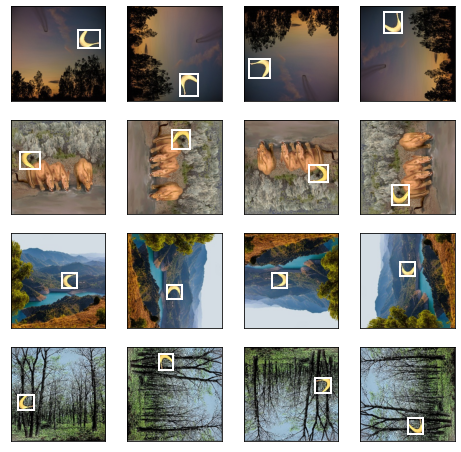

In [ ]:
# 1. Defina el valor de la variable batch_size
# batch_size =  None
batch_size = 16
edge_size = 256
train_iter, val_iter = load_augmented_bananas(batch_size)
batch_train = next(iter(train_iter))
batch_val = next(iter(val_iter))

# 2. Defina minilote a usar dataloader a utilizar
#batch = None
batch = batch_val
imgs = (batch[0].permute(0, 2, 3, 1)) / 255
axes = show_images(imgs, 4, 4, scale=2)
for ax, label in zip(axes, batch[1]):
    show_bboxes(ax, [label[0][1:5] * edge_size], colors=['w'])

## Ejercicio 3

Es posible que las transformaciones aplicadas a las bounding boxes sean incorrectas, pesar de que las imagenes anteriores se ven correctamente con sus bounding boxes

Esto puede deberse a que durante la rotación, pasamos de tener la esquina superior izquierda y la inferior derecha, a tener las superior derecha y las inferior izquierda.

Utilice el siguiente código para verificar que esto no ocurra. Si su transformación de coordenadas actúa correctamente, debería obtener a la salida `tensor(True)`

A partir de la variable `batch` del punto anterior defina la variable `boxes` que contiene las bounding boxes de nuestra etiqueta.

Recuerde que 

* La varaible `batch` es un par con dos elementos
  * El primer elemento es la imagen RGB
  * El segunda elemento es nuestra etiqueta.
    * La etiqueta es un tensor de la forma 

      `[tamaño de minilote, número de objetos a detectar, 5]`

      ¿Cuántos objetos estamos detectando?
      ¿A que se corresponden esos 5 valores?
* La función `offset_boxes` recibe un tensor de la forma

    `[tamaño de minilote * número de objetos a detectar, 4]`
    
  ¿Cuáles son los 4 de los 5 valores anteriores que debemos usar en la función `offset_boxes` ?


In [ ]:
# defina la varaible boxes
# boxes = None

boxes = batch[1].reshape(-1,5)[:,1:]

centered_boxes = box_corner_to_center(boxes)
offsets = offset_boxes(centered_boxes[0].unsqueeze(0),centered_boxes)
print(torch.isnan(offsets).sum() == 0)

tensor(False)


# Modelo

In [ ]:

%matplotlib inline
import torch
import torchvision
from torch import nn
from torch.nn import functional as F


def cls_predictor(num_inputs, num_anchors, num_classes):
    return nn.Conv2d(num_inputs, num_anchors * (num_classes + 1),
                     kernel_size=3, padding=1)

In [ ]:
def bbox_predictor(num_inputs, num_anchors):
    return nn.Conv2d(num_inputs, num_anchors * 4, kernel_size=3, padding=1)

In [ ]:
def forward(x, block):
    return block(x)


In [ ]:
def flatten_pred(pred):
    return torch.flatten(pred.permute(0, 2, 3, 1), start_dim=1)

def concat_preds(preds):
    return torch.cat([flatten_pred(p) for p in preds], dim=1)

In [ ]:
def down_sample_blk(in_channels, out_channels):
    blk = []
    for _ in range(2):
        blk.append(nn.Conv2d(in_channels, out_channels,
                             kernel_size=3, padding=1))
        blk.append(nn.BatchNorm2d(out_channels))
        blk.append(nn.ReLU())
        in_channels = out_channels
    blk.append(nn.MaxPool2d(2))
    return nn.Sequential(*blk)

In [ ]:
def base_net():
    blk = []
    num_filters = [3, 16, 32, 64]
    for i in range(len(num_filters) - 1):
        blk.append(down_sample_blk(num_filters[i], num_filters[i+1]))
    return nn.Sequential(*blk)

torch.Size([2, 64, 32, 32])

In [ ]:
def get_blk(i):
    if i == 0:
        blk = base_net()
    elif i == 1:
        blk = down_sample_blk(64, 128)
    elif i == 4:
        blk = nn.AdaptiveMaxPool2d((1,1))
    else:
        blk = down_sample_blk(128, 128)
    return blk

In [ ]:
def blk_forward(X, blk, size, ratio, cls_predictor, bbox_predictor):
    Y = blk(X)
    anchors = multibox_prior(Y, sizes=size, ratios=ratio)
    cls_preds = cls_predictor(Y)
    bbox_preds = bbox_predictor(Y)
    return (Y, anchors, cls_preds, bbox_preds)

In [ ]:
sizes = [[0.2, 0.272], [0.37, 0.447], [0.54, 0.619], [0.71, 0.79],
         [0.88, 0.961]]
ratios = [[1, 2, 0.5]] * 5
num_anchors = len(sizes[0]) + len(ratios[0]) - 1

In [ ]:
class TinySSD(nn.Module):
    def __init__(self, num_classes, **kwargs):
        super(TinySSD, self).__init__(**kwargs)
        self.num_classes = num_classes
        idx_to_in_channels = [64, 128, 128, 128, 128]
        for i in range(5):
            # Equivalent to the assignment statement `self.blk_i = get_blk(i)`
            setattr(self, f'blk_{i}', get_blk(i))
            setattr(self, f'cls_{i}', cls_predictor(idx_to_in_channels[i],
                                                    num_anchors, num_classes))
            setattr(self, f'bbox_{i}', bbox_predictor(idx_to_in_channels[i],
                                                      num_anchors))

    def forward(self, X):
        anchors, cls_preds, bbox_preds = [None] * 5, [None] * 5, [None] * 5
        for i in range(5):
            # Here `getattr(self, 'blk_%d' % i)` accesses `self.blk_i`
            X, anchors[i], cls_preds[i], bbox_preds[i] = blk_forward(
                X, getattr(self, f'blk_{i}'), sizes[i], ratios[i],
                getattr(self, f'cls_{i}'), getattr(self, f'bbox_{i}'))
        anchors = torch.cat(anchors, dim=1)
        cls_preds = concat_preds(cls_preds)
        cls_preds = cls_preds.reshape(
            cls_preds.shape[0], -1, self.num_classes + 1)
        bbox_preds = concat_preds(bbox_preds)
        return anchors, cls_preds, bbox_preds

# Entrenamiento


## Inicialización del pipeline

In [ ]:

batch_size = 128
train_iter, val_iter = load_augmented_bananas(batch_size)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = TinySSD(num_classes=1)
trainer = torch.optim.SGD(net.parameters(), lr=0.2, weight_decay=5e-4)

read 4000 training examples
read 400 validation examples


In [ ]:
cls_loss = nn.CrossEntropyLoss(reduction='none')
bbox_loss = nn.L1Loss(reduction='none')

def calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks):
    batch_size, num_classes = cls_preds.shape[0], cls_preds.shape[2]
    cls = cls_loss(cls_preds.reshape(-1, num_classes),
                   cls_labels.reshape(-1)).reshape(batch_size, -1).mean(dim=1)
    bbox = bbox_loss(bbox_preds * bbox_masks,
                     bbox_labels * bbox_masks).mean(dim=1)
    return cls + bbox

In [ ]:
def cls_eval(cls_preds, cls_labels):
    # Because the class prediction results are on the final dimension,
    # `argmax` needs to specify this dimension
    return float((cls_preds.argmax(dim=-1).type(
        cls_labels.dtype) == cls_labels).sum())

def bbox_eval(bbox_preds, bbox_labels, bbox_masks):
    return float((torch.abs((bbox_labels - bbox_preds) * bbox_masks)).sum())

## Entrenamiento

In [ ]:
num_epochs= 30

net = net.to(device)

best_valid_loss = float('inf')
for epoch in range(num_epochs):

    # Sum of training accuracy, no. of examples in sum of training accuracy,
    # Sum of absolute error, no. of examples in sum of absolute error
    cls_err, cls_elem, bbox_mae, bbox_elem = 0, 0, 0, 0
    loss, loss_elem = 0, 0
    net.train()
    for features, target in train_iter:
        trainer.zero_grad()
        X, Y = features.to(device), target.to(device)
        # Generate multiscale anchor boxes and predict their classes and
        # offsets
        anchors, cls_preds, bbox_preds = net(X)
        # Label the classes and offsets of these anchor boxes
        bbox_labels, bbox_masks, cls_labels = multibox_target(anchors, Y)
        # Calculate the loss function using the predicted and labeled values
        # of the classes and offsets
        l = calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels,
                      bbox_masks)
        loss += l.sum()
        loss_elem += l.numel()
        l.mean().backward()
        trainer.step()
        
        cls_err += cls_eval(cls_preds, cls_labels)
        cls_elem += cls_labels.numel()
        bbox_mae += bbox_eval(bbox_preds, bbox_labels, bbox_masks)
        bbox_elem += bbox_labels.numel()
    cls_err, bbox_mae, loss = 1 - cls_err / cls_elem, bbox_mae / bbox_elem, loss / loss_elem
    
    
    val_loss, val_loss_elem = 0, 0
    net.eval()
    with torch.no_grad():
        for features, target in val_iter:
            trainer.zero_grad()
            X, Y = features.to(device), target.to(device)
            # Generate multiscale anchor boxes and predict their classes and
            # offsets
            anchors, cls_preds, bbox_preds = net(X)
            # Label the classes and offsets of these anchor boxes
            bbox_labels, bbox_masks, cls_labels = multibox_target(anchors, Y)
            # Calculate the loss function using the predicted and labeled values
            # of the classes and offsets
            l = calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels,
                          bbox_masks)
            val_loss += l.sum()
            val_loss_elem += l.numel()
        val_loss = val_loss / val_loss_elem

    if val_loss < best_valid_loss:
        best_valid_loss = val_loss
        torch.save(net.state_dict(), 'augmented_banana.pt')


    print(f'EPOCH: {epoch + 1}')
    print(f'    training loss {loss:.2e}')
    print(f'    validation loss {val_loss:.2e}')
    print(f'    class err {cls_err:.2e}')
    print(f'    bbox mae {bbox_mae:.2e}')


# Prediccion

Tratemos de replicar la figura inicial 

<img src="https://i.imgur.com/MQydvw9.png" width="600"/>


## Ejercicio 4

Genere 4 copias de la imagen `banana.jpg`, cada una rotada 0°, 90°, 180° y 270°

Luego verifique que las predicciones de nuestro modelo, ahora reconocen orientaciones con un umbral de más del 90%

In [ ]:
!wget -O banana.jpg https://raw.githubusercontent.com/d2l-ai/d2l-en/master/img/banana.jpg
X = torchvision.io.read_image('banana.jpg').unsqueeze(0).float()

# implemente las rotaciones en las variables X, X2, X3, X4
# X = None
# X2 = None
# X3 = None
# X4 = None
X2 = X[:,:,range(255,-1,-1),:].permute(0,1,3,2)
X3 = X2[:,:,range(255,-1,-1),:].permute(0,1,3,2)
X4 = X3[:,:,range(255,-1,-1),:].permute(0,1,3,2)


img = X.squeeze(0).permute(1, 2, 0).long()
img2 = X2.squeeze(0).permute(1, 2, 0).long()
img3 = X3.squeeze(0).permute(1, 2, 0).long()
img4 = X4.squeeze(0).permute(1, 2, 0).long()

In [ ]:
def predict(X):
    net.eval()
    anchors, cls_preds, bbox_preds = net(X.to(device))
    cls_probs = F.softmax(cls_preds, dim=2).permute(0, 2, 1)
    output = multibox_detection(cls_probs, bbox_preds, anchors)
    idx = [i for i, row in enumerate(output[0]) if row[0] != -1]
    return output[0, idx]

net.load_state_dict(torch.load('augmented_banana.pt'))

output = predict(X)
output2 = predict(X2)
output3 = predict(X3)
output4 = predict(X4)

Visualicemos el resultado

In [ ]:
def display(img, output, threshold):
    fig = plt.imshow(img)
    for row in output:
        score = float(row[1])
        if score < threshold:
            continue
        h, w = img.shape[:2]
        bbox = [row[2:6] * torch.tensor((w, h, w, h), device=row.device)]
        show_bboxes(fig.axes, bbox, '%.2f' % score, 'w')


In [ ]:
display(img, output.cpu(), threshold=0.9)

In [ ]:
display(img2, output2.cpu(), threshold=0.9)

In [ ]:
display(img3, output3.cpu(), threshold=0.9)

In [ ]:
display(img4, output4.cpu(), threshold=0.9)